# Automatic grading of student responses in natural language

## TODO

1. ✅ Import des données.
2. ❌ Utiliser clé API ChatGPT est faire des essais avec sur le dataset.
2. ✅ Importer Gemma.
3. ✅ Faire des essaies sur le modèle.
4. ✅ Trouver un promt pour évaluer une réponse et donner un feedback (à partir de la réponse référente du prof)
5. ✅ Fine tuner le modèle
6. ❌ Sauvegarder le modèle fine tuné
7. ❌ Charger une sauvegarde
8. Améliorer l'entraînement
9. ✅ Evaluer le modèle
10. Comparer les modèles sauvegardés


## README

This project involves using LLM (Large Language Model) for the automatic grading of student responses in natural language.


## Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import json
!pip install json-repair
import json_repair

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from gensim.models import Word2Vec
from scipy.spatial.distance import cosine
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import os
import datetime

from rich.progress import Progress, BarColumn, TextColumn, TaskProgressColumn, TimeRemainingColumn, TimeElapsedColumn

({'key': 'value', 'key2': ''}, [{'text': 'At the end of an object we found a key with missing value, skipping', 'context': ', "key2": }'}])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Execution mode

In [2]:
# @markdown This jupyter notebook can either be run on Google colab or on a local machine.

# @markdown Please select your computation mode:
computation_mode = "Google Colab" # @param ["Google Colab", "Local"]

if computation_mode == "Google Colab":
    from google.colab import drive
    print("Connecting to Google Drive...")


    # Drive connection
    drive.mount('/content/drive')

    # Path when the files are in a shared drive
    path = '"/content/drive/Shareddrives/ING3 IA & applications 2/"'

    # Move in directories
    %cd $path

else:
    path = './'
    print("Executing with local datas")

Connecting to Google Drive...
Mounted at /content/drive
/content/drive/Shareddrives/ING3 IA & applications 2


## Dataset

In [3]:
df = pd.read_csv("Dataset/asag_dataset.csv", index_col=0)

In [4]:
df.head()

,question,student_answer,grades_round,student_modified,ref_answer,qn_modified,ref_modified,student_demoted,ref_demoted,length_ratio,...,embed_ref_demoted,embed_stud_demoted,aligned,aligned_demoted,cos_similarity,cos_similarity_demo,aligned_score,aligned_score_demo,question_id,feedback
0,"Give a definition for the term ""artificial ne...",An artificial neural network is a massively pa...,2,artificial neural network massively parallel d...,A neural network is a massively parallel distr...,give definition term artificial neural network...,neural network massively parallel distributed ...,massively parallel distributed processor simpl...,massively parallel distributed processor made ...,0.251889,...,[[ 1.6300049e+00 1.5985355e+00 -1.2829590e-01...,[[ 2.0412598e+00 4.9321938e-01 1.0058594e-01...,"[['neural', 'neural'], ['network', 'network'],...","[['simple', 'simple'], ['processing', 'process...",0.947867,0.933466,0.969697,0.950888,1,The student's answer is partially correct but ...
1,"Give a definition for the term ""artificial ne...",Artificial neural network consists of: . Large...,2,artificial neural network consists largely par...,A neural network is a massively parallel distr...,give definition term artificial neural network...,neural network massively parallel distributed ...,consists largely parallel distributed processo...,massively parallel distributed processor made ...,0.232759,...,[[ 1.6300049e+00 1.5985355e+00 -1.2829590e-01...,[[ 1.19566895 0.7539518 0.13561035 1.22295...,"[['knowledge', 'knowledge'], ['parallel', 'par...","[['knowledge', 'knowledge'], ['knowledge', 'kn...",0.964398,0.951182,0.883259,0.818713,1,The student's answer is precise and covers the...
2,"Give a definition for the term ""artificial ne...",An artificial neural network is a massive dist...,1,artificial neural network massive distributed ...,A neural network is a massively parallel distr...,give definition term artificial neural network...,neural network massively parallel distributed ...,massive distributed processor consists several...,massively parallel distributed processor made ...,0.102828,...,[[ 1.6300049e+00 1.5985355e+00 -1.2829590e-01...,[[ 3.84277344e-01 -4.89446640e-01 1.72241211e...,"[['knowledge', 'knowledge'], ['neural', 'neura...","[['knowledge', 'knowledge'], ['distributed', '...",0.854767,0.775333,0.498039,0.465632,1,The answer given by the student is off-topic a...
3,"Give a definition for the term ""artificial ne...",An ANN is a layered graphical model containing...,2,ann layered graphical model containing neuron ...,A neural network is a massively parallel distr...,give definition term artificial neural network...,neural network massively parallel distributed ...,ann layered graphical model containing neuron ...,massively parallel distributed processor made ...,0.327616,...,[[ 1.6300049e+00 1.5985355e+00 -1.2829590e-01...,[[ 1.97546387e+00 1.12967682e+00 -6.56402588e...,"[['resemble', 'resembling'], ['neural', 'neuro...","[['environment', 'environment'], ['learning', ...",0.788166,0.735229,0.322950,0.220386,1,The student's answer provides a reasonable def...
4,"Give a definition for the term ""artificial ne...",Artificial Neural Networks are large parallel ...,2,artificial neural network large parallel proce...,A neural network is a massively parallel distr...,give definition term artificial neural network...,neural network massively parallel distributed ...,large parallel processing unit natural ability...,massively parallel distributed processor made ...,0.286963,...,[[ 1.6300049e+00 1.5985355e+00 -1.2829590e-01...,[[ 0.68797852 0.72406174 -0.85735535 1.14616...,"[['knowledge', 'knowledge'], ['processing', 'p...","[['knowledge', 'knowledge'], ['processing', 'p...",0.894408,0.828665,0.585639,0.482094,1,The student's answer is partially correct as i...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 607 entries, 0 to 644
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   question             607 non-null    object 
 1   student_answer       607 non-null    object 
 2   grades_round         607 non-null    int64  
 3   student_modified     606 non-null    object 
 4   ref_answer           607 non-null    object 
 5   qn_modified          607 non-null    object 
 6   ref_modified         607 non-null    object 
 7   student_demoted      606 non-null    object 
 8   ref_demoted          607 non-null    object 
 9   length_ratio         607 non-null    float64
 10  embed_ref            607 non-null    object 
 11  embed_stud           607 non-null    object 
 12  embed_ref_demoted    607 non-null    object 
 13  embed_stud_demoted   607 non-null    object 
 14  aligned              607 non-null    object 
 15  aligned_demoted      607 non-null    object 


- **question**: The question that was asked.
- **student_answer**: The answer provided by the student.
- **grades_round**: The grade assigned to the student's answer.
- **student_modified**: The student's answer after some preprocessing like lowercasing, removing punctuation, etc.
- **ref_answer**: A reference answer for the question.
- **qn_modified**: The question after some preprocessing.
- **ref_modified**: The reference answer after some preprocessing.
- **student_demoted**: The student's answer after some further preprocessing, possibly removing less important words.
- **ref_demoted**: The reference answer after some further preprocessing.
- **length_ratio**: The ratio of the length of the student's answer to the length of the reference answer.
- **embed_stud, embed_ref_demoted, embed_stud_demoted**: These columns likely contain embeddings (numerical representations) of the student's answer, the demoted reference answer, and the demoted student's answer, respectively.
- **aligned, aligned_demoted**: These columns likely contain information about which words in the student's answer and the reference answer are aligned (i.e., match or are similar).
- **cos_similarity, cos_similarity_demo**: These columns likely contain the cosine similarity (a measure of similarity between two vectors) between the embeddings of the student's answer and the reference answer, and between the demoted versions of these, respectively.
- **aligned_score, aligned_score_demo**: These columns likely contain scores based on how well the student's answer aligns with the reference answer, for both the original and demoted versions.
- **question_id**: An identifier for the question.

- **feedback**: feedback generated by Gemini Pro (cf `Construct feedback column` section)

In [6]:
df = df.dropna(subset=["student_answer"])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 607 entries, 0 to 644
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   question             607 non-null    object 
 1   student_answer       607 non-null    object 
 2   grades_round         607 non-null    int64  
 3   student_modified     606 non-null    object 
 4   ref_answer           607 non-null    object 
 5   qn_modified          607 non-null    object 
 6   ref_modified         607 non-null    object 
 7   student_demoted      606 non-null    object 
 8   ref_demoted          607 non-null    object 
 9   length_ratio         607 non-null    float64
 10  embed_ref            607 non-null    object 
 11  embed_stud           607 non-null    object 
 12  embed_ref_demoted    607 non-null    object 
 13  embed_stud_demoted   607 non-null    object 
 14  aligned              607 non-null    object 
 15  aligned_demoted      607 non-null    object 


In [8]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=1337, stratify=df['grades_round'])

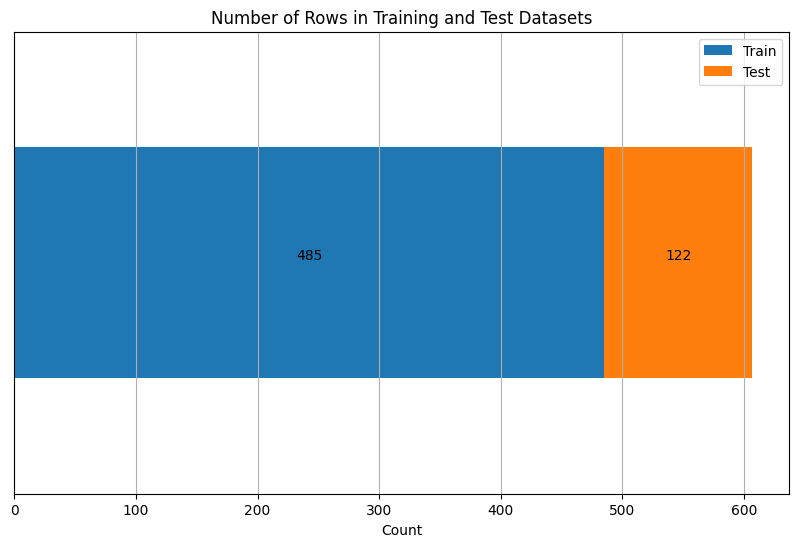

In [9]:
# Count the number of rows in the training and test datasets
train_count = len(train_df)
test_count = len(test_df)

# Create a DataFrame with the counts
counts_df = pd.DataFrame({'Train': [train_count], 'Test': [test_count]})

# Create the plot
ax = counts_df.plot(kind='barh', stacked=True, figsize=(10,6))

# Add the counts on top of the bars
for rect in ax.patches:
    width = rect.get_width()
    ax.text(rect.get_x() + width / 2, rect.get_y() + rect.get_height() / 2,
            int(width), ha='center', va='bottom')

plt.title('Number of Rows in Training and Test Datasets')
plt.xlabel('Count')
plt.grid(True)
plt.yticks([])
plt.show()

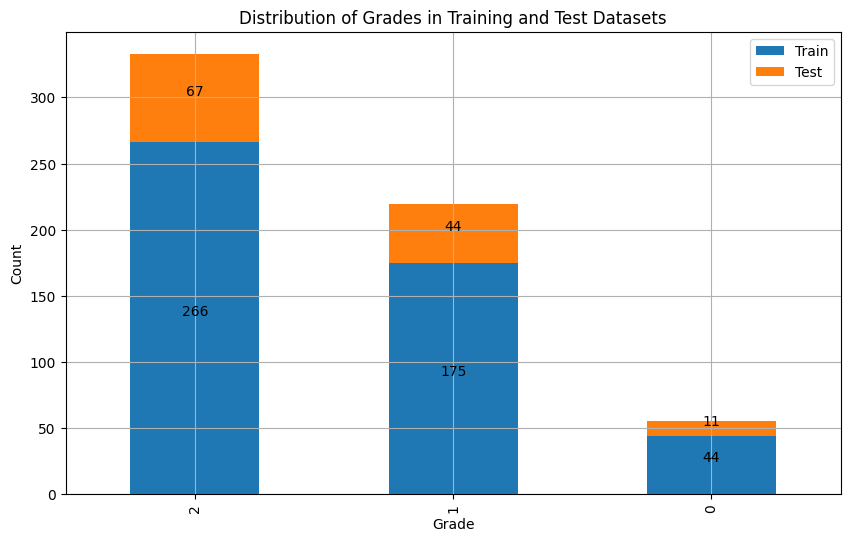

In [10]:
# Count the number of each grade in the training dataset
train_grade_counts = train_df['grades_round'].value_counts()

# Count the number of each grade in the test dataset
test_grade_counts = test_df['grades_round'].value_counts()

# Create a DataFrame with the counts
grade_counts_df = pd.DataFrame({'Train': train_grade_counts, 'Test': test_grade_counts})

# Create the plot
ax = grade_counts_df.plot(kind='bar', stacked=True, figsize=(10,6))

# Add the counts on top of the bars
for rect in ax.patches:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_y() + height / 2,
            int(height), ha='center', va='bottom')

plt.title('Distribution of Grades in Training and Test Datasets')
plt.xlabel('Grade')
plt.ylabel('Count')
plt.grid(True)
plt.show()

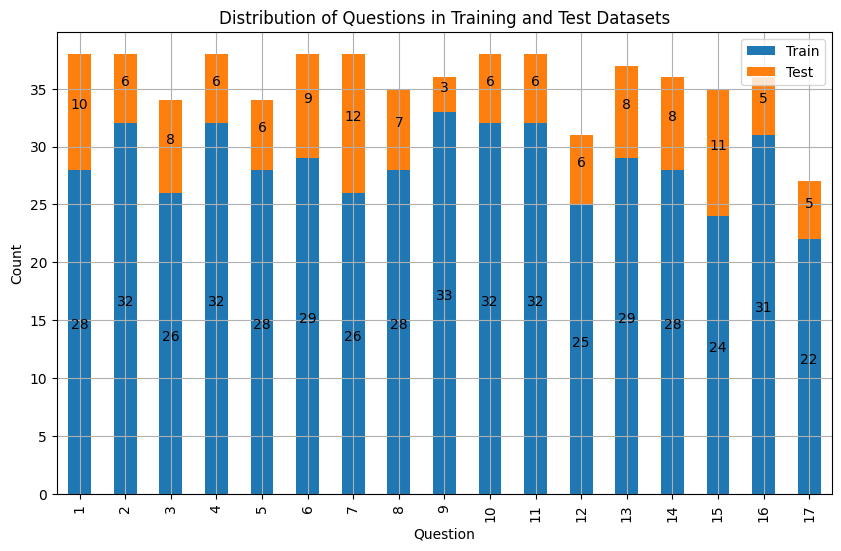

In [11]:
# Count the number of each question in the training dataset
train_question_counts = train_df['question_id'].value_counts()

# Count the number of each question in the test dataset
test_question_counts = test_df['question_id'].value_counts()

# Create a DataFrame with the counts
question_counts_df = pd.DataFrame({'Train': train_question_counts, 'Test': test_question_counts})

# Create the plot
ax = question_counts_df.plot(kind='bar', stacked=True, figsize=(10,6))

# Add the counts on top of the bars
for rect in ax.patches:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_y() + height / 2,
            int(height), ha='center', va='bottom')

plt.title('Distribution of Questions in Training and Test Datasets')
plt.xlabel('Question')
plt.ylabel('Count')
plt.grid(True)
plt.show()

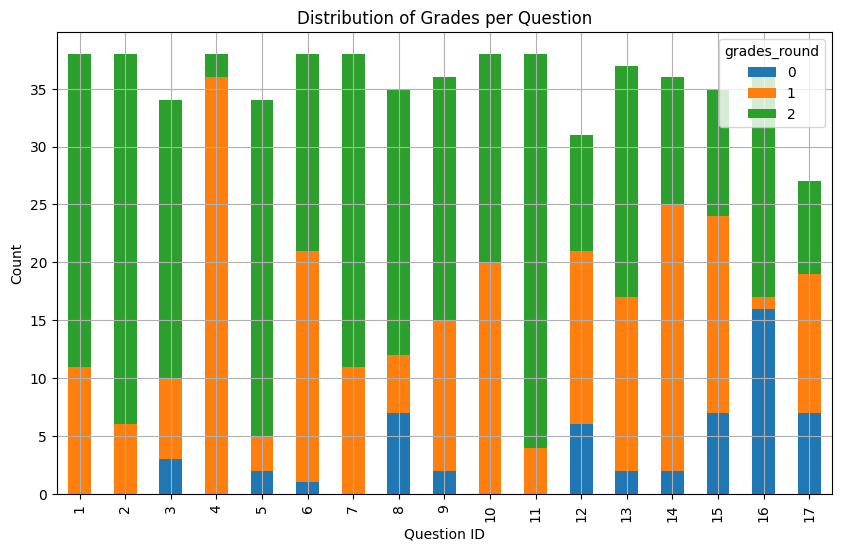

In [12]:
# Group by 'question_id' and 'grades_round' and count the number of answers in each group
num_answers = df.groupby(['question_id', 'grades_round'])['student_answer'].count().unstack()

# Create the plot
num_answers.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('Distribution of Grades per Question')
plt.xlabel('Question ID')
plt.ylabel('Count')
plt.grid(True)
plt.show()

## LLM

In [13]:
# @title Model choice

# @markdown Choose the LLM model you want to use.

model_choice = "Gemma" # @param ["Mistral", "Gemma", "Gemini", "Perplexity", "Flan"]

if model_choice == "Mistral":
    raise Exception("Not implemented yet")
elif model_choice == "Gemma":
    print("Using Gemma...")
elif model_choice == "Gemini":
    print("Using Gemini...")
elif model_choice == "Perplexity":
    raise Exception("Not implemented yet")
elif model_choice == "Flan":
    raise Exception("Not implemented yet")

Using Gemma...


### Auxiliary functions

In [14]:
# Get loop iteration progress bar
def get_progress_bar(len):
    progress = Progress(
        TextColumn("[progress.description]{task.description}"),
        BarColumn(),
        TaskProgressColumn(),
        TextColumn("[green]Remaining"),
        TimeRemainingColumn(),
        TextColumn("[green]Elapsed"),
        TimeElapsedColumn()
    )

    task = progress.add_task("[green]Processing...", total=len)

    return progress, task

# Fixes JSON if needed and returns the value
def extract_json_value(json, key):
    try:
        response_dict = json_repair.loads(json)
        return response_dict.get(key)
    except Exception as e:
        print("Extract_json_value exception. Input:", json)
        return None

In [15]:
# Plot sklearn classification_report and confusion_matrix on the same figure
def plot_classification_report_and_cm(y_true, y_pred, model_choice=model_choice):
    assert len(y_true) == len(y_pred)

    # Create a DataFrame from the classification report
    report_df = pd.DataFrame(classification_report(y_true, y_pred, output_dict=True, zero_division=1.0)).transpose()

    # Format the remaining columns to two decimal places
    report_df = report_df.applymap(lambda x: "{:.2f}".format(x))

    # Convert the 'support' column to integers
    report_df['support'] = report_df['support'].str.split('.').str[0].astype(int)

    report_df.loc['accuracy', 'support'] = report_df.loc['macro avg', 'support']

    # Create the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels = [0, 1, 2])

    # Create figure and subplots
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))

    # Add a main title
    fig.suptitle(f'{model_choice} Grades Evaluation', fontsize=16)

    # Create classification report table
    table = ax1.table(
        cellText=report_df.values,
        rowLabels=report_df.index,
        colLabels=report_df.columns,
        loc='center',
        cellLoc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.5, 1.5)
    ax1.axis('off')
    ax1.set_title('Classification Report')

    # Create Seaborn heatmap
    sns.heatmap(cm, annot=True, cmap='Blues', ax=ax2)
    ax2.set_title('Confusion Matrix')
    ax2.set_xlabel('Predicted Label')
    ax2.set_ylabel('True Label')

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

In [16]:
# Preprocessing
stop_words = set(stopwords.words('english'))
def preprocess_feedback(text):
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.casefold() not in stop_words]
    return " ".join(filtered_text)

# Evaluation
def get_feedback_similarity(generated_feedback, actual_feedback):
    preprocessed_generated = preprocess_feedback(generated_feedback)
    preprocessed_actual = preprocess_feedback(actual_feedback)

    # Train Word2Vec model
    model = Word2Vec([preprocessed_generated.split(), preprocessed_actual.split()], min_count=1)

    # Get average vector for each feedback
    vector_generated = np.mean([model.wv[word] for word in preprocessed_generated.split()], axis=0)
    vector_actual = np.mean([model.wv[word] for word in preprocessed_actual.split()], axis=0)

    # Calculate cosine similarity
    similarity = 1 - cosine(vector_generated, vector_actual)

    return similarity

def plot_text_similarity_statistics(df1, df2):
    assert len(df1) == len(df2)

    similarities = []
    mismatched_indexes = []

    common_indexes = df1.index.intersection(df2.index)

    for idx in common_indexes:
        similarity = get_feedback_similarity(df1.loc[idx], df2.loc[idx])
        similarities.append(similarity)

    # Generate descriptive statistics
    stats = pd.Series(similarities).describe().round(2)
    stats_df = pd.DataFrame(stats)

    # Create figure and subplots
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 3), width_ratios=[0.3, 0.7])

    # Add a main title
    fig.suptitle(f'{model_choice} Feedbacks Evaluation', fontsize=16)

    # Create statistics table
    table = ax1.table(cellText=stats_df.values,
                      colLabels=stats_df.columns,
                      rowLabels=stats_df.index,
                      cellLoc = 'center',
                      loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.5, 1.5)
    ax1.axis('off')
    ax1.set_title('Statistics')

    # Plot histogram
    ax2.hist(similarities, bins=20, alpha=0.5)
    ax2.set_title('Distribution of Cosine Similarities in Feedbacks')
    ax2.set_xlabel('Cosine Similarity')
    ax2.set_ylabel('Frequency')

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

    # Find indexes present in df1 but not in df2 and vice versa
    df1_not_df2 = df1.index.difference(df2.index)
    df2_not_df1 = df2.index.difference(df1.index)

    if not df1_not_df2.empty or not df2_not_df1.empty:
        print("Indexes in df1 but not in df2: ", df1_not_df2.tolist())
        print("Indexes in df2 but not in df1: ", df2_not_df1.tolist())
        raise Exception("Indexes mismatch between df1 and df2")


### Gemini

To be able to access Gemini API, you might have to use VPN in one of the countries from https://ai.google.dev/available_regions (USA seems to be a bit quicker than others)

⚠️ Don't interrupt execution while Gemini API is being requested. Otherwise you'll have to restart session.

#### Define model

[Documentation](https://ai.google.dev/tutorials/python_quickstart)

⚠️ Please follow API key setup section: https://ai.google.dev/tutorials/python_quickstart#setup_your_api_key

In [17]:
# imports python SDK for the Gemini API
!pip install -q -U google-generativeai

import google.generativeai as genai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.8/146.8 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.5/664.5 kB 12.9 MB/s eta 0:00:00


In [18]:
# setup api key
from google.colab import userdata

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')

genai.configure(api_key=GOOGLE_API_KEY)

SecretNotFoundError: Secret GOOGLE_API_KEY does not exist.

In [ ]:
print("Available models:")
for m in genai.list_models():
  if 'generateContent' in m.supported_generation_methods:
    print(m.name)

In [ ]:
# define model
model = genai.GenerativeModel('gemini-pro')
model

In [ ]:
# test model
response = model.generate_content("Hi, who are you?")
print(response.text)

#### Define file path to model results

In [ ]:
# Get model results file
try:
    results_df = pd.read_csv(f'Results/{model_choice}_results.csv', index_col=0)
except FileNotFoundError:
    results_df = pd.DataFrame()

#### Auxiliary functions

Tested both sending prompts independently and using chat to define instructions only once. Second option is slower since it handles the chat history.

In [ ]:
def extract_data_from_model_response(response, keys=[]):
    response = response.text
    response = response[response.find('{'):response.rfind('}') + 1]

    extracted_data = {}
    for key in keys:
        extracted_data[key] = extract_json_value(response, key)

    return extracted_data

def get_prompt(question, student_answer, ref_answer, prompt_type, examples_df=None):
    base_prompt = f"""
    ## Question:

    {question}

    ## Student Answer:

    {student_answer}

    ## Reference Answer:

    {ref_answer}
    """

    if prompt_type == '0shot':
        task_prompt = """
    ## Task:

    1. Evaluate the student's answer in comparison to the reference answer.
    * The focus should be on the understanding of the main ideas rather than the exact wording or completeness.

    Consider the following grading scheme:
    * **2:** Answer that captures the essence of the reference answer, even if details are omitted or there are errors.
    * **1:** Answer that partially captures the essence of the reference answer, but misses significant points or contains major errors.
    * **0:** Answer that does not capture the essence of the reference answer at all.

    2. Provide concise feedback that highlights the strengths and weaknesses of their response, justifying the assigned grade.
    * Feedback should be a phrase.
    * Feedback should include assigned grade.

    3. Please generate a JSON response containing the grade and the feedback.
    """
    elif prompt_type == '0shot_cot':
        task_prompt = """
    ## Task:

    1. Read the question, student's answer, and the reference answer.

    2. Evaluate the student's answer in comparison to the reference answer.
    * The focus should be on the understanding of the main ideas rather than the exact wording or completeness.

    3. Consider the context of the question and answer.
    * The context can include the subject matter, the level of detail required by the question, and the appropriateness of the student's answer given the question.

    4. Consider the following grading scheme:
        * **2:** Answer that captures the essence of the reference answer, even if details are omitted or there are errors.
        * **1:** Answer that partially captures the essence of the reference answer, but misses significant points or contains major errors.
        * **0:** Answer that does not capture the essence of the reference answer at all.

    5. Provide concise feedback that highlights the strengths and weaknesses of their response, justifying the assigned grade.
    * Feedback should be a phrase.
    * Feedback should include assigned grade.

    6. Please generate a JSON response containing the grade and the feedback.
    """
    elif prompt_type == 'fewshot_cot' or prompt_type == 'fewshot_cot_tuned':
        if examples_df is None or len(examples_df) < 1:
            raise Exception("At least one example is required for few-shot prompts")

        example_prompts = ""
        for _, example in examples_df.iterrows():
            example_prompts += f"""
    ## Example:

    ### Question:

    {example['question']}

    ### Student Answer:

    {example['student_answer']}

    ### Reference Answer:

    {example['ref_answer']}

    ### Grade:

    {example['grades_round']}
    """

        task_prompt = f"""
    ## Task:

    1. Read the question, student's answer, and the reference answer.

    2. Evaluate the student's answer in comparison to the reference answer.
    * The focus should be on the understanding of the main ideas rather than the exact wording or completeness.

    3. Consider the context of the question and answer.
    * The context can include the subject matter, the level of detail required by the question, and the appropriateness of the student's answer given the question.

    4. Consider the following grading scheme:
        * **2:** Answer that captures the essence of the reference answer, even if details are omitted or there are errors.
        * **1:** Answer that partially captures the essence of the reference answer, but misses significant points or contains major errors.
        * **0:** Answer that does not capture the essence of the reference answer at all.

    5. Provide concise feedback that highlights the strengths and weaknesses of their response, justifying the assigned grade.
    * Feedback should be a phrase.
    * Feedback should include assigned grade.

    6. Please generate a JSON response containing the grade and the feedback.

    {example_prompts}
    """

    return base_prompt + task_prompt

def test_model(prompt_type, test_df=test_df, results_df=results_df, model=model, model_choice=model_choice, examples_df=None, debug_loop_limit=None, verbose=False):
    progress, task = get_progress_bar(len(test_df))

    results_grades_col_nm = f'{model_choice}_grade_{prompt_type}'
    results_feedbacks_col_nm = f'{model_choice}_feedback_{prompt_type}'

    if results_grades_col_nm in results_df.columns:
        results_df.drop([results_grades_col_nm], axis=1, inplace=True)

    if results_feedbacks_col_nm in results_df.columns:
        results_df.drop([results_feedbacks_col_nm], axis=1, inplace=True)

    with progress:
        for index, row in test_df.iterrows():
            if debug_loop_limit is not None and progress.tasks[task].completed >= debug_loop_limit:
                return

            question = row['question']
            student_answer = row['student_answer']
            ref_answer= row['ref_answer']

            prompt = get_prompt(question, student_answer, ref_answer, prompt_type, examples_df=examples_df)

            if model_choice == "Mistral":
                raise Exception("Not implemented yet")
            elif model_choice == "ChatGPT":
                raise Exception("Not implemented yet")
            elif model_choice == "Gemini":
                response = model.generate_content(prompt)
            elif model_choice == "Perplexity":
                raise Exception("Not implemented yet")
            elif model_choice == "Flan":
                raise Exception("Not implemented yet")

            response_data = extract_data_from_model_response(response, ["grade", "feedback"])
            grade = response_data["grade"]
            feedback = response_data["feedback"]

            if grade is not None:
                results_df.loc[index, results_grades_col_nm] = int(f'{grade}')
            else:
                results_df.loc[index, results_grades_col_nm] = grade

            results_df.loc[index, results_feedbacks_col_nm] = feedback

            progress.update(task, advance=1)

            if verbose:
                error = f", ❌ Index: {index}" if grade != row['grades_round'] else ""
                print(f"LLM Grade: {grade}, Dataset Grade: {row['grades_round']}{error}")

    results_df[results_grades_col_nm] = pd.to_numeric(results_df[results_grades_col_nm], errors='coerce', downcast='integer')

In [ ]:
def get_feedback_prompts(df=df, debug_loop_limit=None, rows=None):
    progress, task = get_progress_bar(len(df))

    feedback_prompts = []

    if rows is None:
        rows = df.index

    with progress:
        for index in rows:
            row = df.loc[index]
            if debug_loop_limit is not None and progress.tasks[task].completed >= debug_loop_limit:
                return pd.concat(feedback_prompts, ignore_index=False)

            question = row['question']
            student_answer = row['student_answer']
            ref_answer= row['ref_answer']
            grades_round = row['grades_round']

            prompt = f"""
            ## Question:

            {question}

            ## Student Answer:

            {student_answer}

            ## Reference Answer:

            {ref_answer}

            ## Grade:

            {grades_round}

            ## Task:

            Grade can be between 0 and 2.

            1. Please analyze the student's answer in comparison to the reference answer and provide concise feedback that highlights the strengths and weaknesses of their response, justifying the assigned grade.
            2. Feedback should be a phrase.
            3. Include assigned grade in feedback.
            4. Generate a JSON response containing the feedback.
            """

            feedback_prompts.append(pd.DataFrame({'prompt': [prompt]}, index=[index]))

            progress.update(task, advance=1)
        return pd.concat(feedback_prompts, ignore_index=False)

def get_feedbacks(feedback_prompts, debug_loop_limit=None):
    progress, task = get_progress_bar(len(feedback_prompts))

    feedbacks = []

    with progress:
        for index, row in feedback_prompts.iterrows():
            if debug_loop_limit is not None and progress.tasks[task].completed >= debug_loop_limit:
                return pd.concat(feedbacks, ignore_index=False)

            response = model.generate_content(row['prompt'])

            response_data = extract_data_from_model_response(response, ["feedback"])
            feedback = response_data["feedback"]

            feedbacks.append(pd.DataFrame({'feedback': [feedback]}, index=[index]))

            progress.update(task, advance=1)
        return pd.concat(feedbacks, ignore_index=False)

def construct_feedbacks(df, col_name='feedback'):
    if 'feedback' not in df.columns:
        df['feedback'] = None

    while True:
        null_indexes = pd.isnull(df[col_name]).where(lambda x: x).dropna().index

        if len(null_indexes) == 0:
            break

        lacking_feedback_prompts = get_feedback_prompts(df=df, rows=null_indexes)
        lacking_feedbacks = get_feedbacks(lacking_feedback_prompts)

        df.loc[lacking_feedbacks.index, col_name] = lacking_feedbacks[col_name]

    return df

In [ ]:
def evaluate_model_grades(prompt_type, test_df=test_df, results_df=results_df, model_choice=model_choice):
    results_grades_col_nm = f'{model_choice}_grade_{prompt_type}'

    num_na = results_df[results_grades_col_nm].isna().sum()
    print(f"Percentage of NaN values in '{results_grades_col_nm}' that we omitted in metrics: {round((num_na / len(test_df)) * 100, 2)}%")

    # Filter out rows with NaN values in results_grades_col_nm
    results_df_filtered = results_df[results_df[results_grades_col_nm].notna()][[results_grades_col_nm]]

    # Filter out rows in test_df that are also in df_filtered
    test_df_filtered = test_df.loc[results_df_filtered.index]

    # Extract the true labels and predicted labels
    y_true = test_df_filtered['grades_round']
    y_pred = results_df_filtered[results_grades_col_nm]

    plot_classification_report_and_cm(y_true, y_pred)

def evaluate_model_feedbacks(prompt_type, test_df=test_df, results_df=results_df, model_choice=model_choice):
    results_grades_col_nm = f'{model_choice}_feedback_{prompt_type}'

    num_na = results_df[results_grades_col_nm].isna().sum()
    print(f"Percentage of NaN values in '{results_grades_col_nm}' that we omitted in metrics: {round((num_na / len(test_df)) * 100, 2)}%")

    # Filter out rows with NaN values in results_grades_col_nm
    results_df_filtered = results_df[results_df[results_grades_col_nm].notna()][[results_grades_col_nm]]

    # Filter out rows in test_df that are also in df_filtered
    test_df_filtered = test_df.loc[results_df_filtered.index]

    # Extract the true labels and predicted labels
    y_true = test_df_filtered['feedback']
    y_pred = results_df_filtered[results_grades_col_nm]

    plot_text_similarity_statistics(y_true, y_pred)


In [ ]:
def get_training_data(train_df=train_df, debug_loop_limit=None):
    progress, task = get_progress_bar(len(train_df))

    training_data = []

    with progress:
        for index, row in train_df.iterrows():
            if debug_loop_limit is not None and progress.tasks[task].completed >= debug_loop_limit:
                return training_data

            question = row['question']
            student_answer = row['student_answer']
            ref_answer= row['ref_answer']
            grades_round = row['grades_round']

            prompt = get_prompt(question, student_answer, ref_answer, "0shot")
            response = json.dumps({
                "grade": grades_round
            })

            training_data.append({
                'text_input': prompt,
                'output': response,
            })

            progress.update(task, advance=1)
        return training_data

#### Construct feedback column

In [ ]:
df = construct_feedbacks(df)

In [ ]:
pd.set_option('display.max_colwidth', None)
df[['grades_round', 'feedback']]

In [ ]:
df.to_csv('Dataset/asag_dataset.csv')

#### 0 shot

In [ ]:
test_model("0shot", debug_loop_limit=5, verbose=True)

In [ ]:
results_df.head()

In [ ]:
evaluate_model_grades("0shot")

In [ ]:
evaluate_model_feedbacks("0shot")

In [ ]:
results_df.to_csv(f'Results/{model_choice}_results.csv')

#### 0 shot, CoT

In [ ]:
test_model("0shot_cot", debug_loop_limit=5, verbose=True)

In [ ]:
results_df.head()

In [ ]:
evaluate_model_grades("0shot_cot")

In [ ]:
evaluate_model_feedbacks("0shot_cot")

In [ ]:
results_df.to_csv(f'Results/{model_choice}_results.csv')

#### few shot, CoT

In [ ]:
examples_df = train_df[train_df['question_id'] == 1].groupby('grades_round').first().reset_index()

test_model("fewshot_cot", verbose=True, examples_df=examples_df, debug_loop_limit=5)

In [ ]:
results_df.head()

In [ ]:
evaluate_model_grades("fewshot_cot")

In [ ]:
evaluate_model_feedbacks("fewshot_cot")

In [ ]:
results_df.to_csv(f'Results/{model_choice}_results.csv')

#### Define tuned model (Google side issues, waiting for solution)

[Documentation](https://ai.google.dev/tutorials/tuning_quickstart_python)

⚠️ GCP Project is currently setup to allow only Damir because of usage quotas. Contact sagdullind@cy-tech.fr if you want to get access.

⚠️ An [issue](https://www.googlecloudcommunity.com/gc/Apigee/503-DNS-Error-for-Gemini-pro-fine-tuning/m-p/728954#M79018) on Google side prevents from making requests to tuned models from API through `grps` as mentioned in the documentation.

⚠️ Since [Python Gemini SDK](https://ai.google.dev/api/python/google/generativeai) doesn't suppor calls to tuned models yet and [REST Gemini SDK](https://ai.google.dev/api/rest) isn't exposed yet in [Python Cloud API Client](https://googleapis.github.io/google-api-python-client/docs/). we can only call tuned models from [UI](https://aistudio.google.com/app) with prompts put 1 by 1...


In [ ]:
import os
if 'COLAB_RELEASE_TAG' in os.environ:
  import pathlib
  pathlib.Path('Configs/gcp_client_secret.json').write_text(userdata.get('CLIENT_SECRET'))

  !gcloud auth application-default login --no-browser --client-id-file Configs/gcp_client_secret.json --scopes='https://www.googleapis.com/auth/cloud-platform,https://www.googleapis.com/auth/generative-language.tuning'
else:
  !gcloud auth application-default login --client-id-file Configs/gcp_client_secret.json --scopes='https://www.googleapis.com/auth/cloud-platform,https://www.googleapis.com/auth/generative-language.tuning'

In [ ]:
# genai.configure(transport="grpc")
genai.configure(transport="rest")

##### Tuning

In [ ]:
print("Available tunable models:")
for m in genai.list_models():
    if all(method in m.supported_generation_methods for method in ["createTunedModel", "generateContent"]):
        print(m.name)

In [ ]:
# define base model
base_model = [
    m for m in genai.list_models()
    if "createTunedModel" in m.supported_generation_methods][0]

print(base_model)
# get training data
training_data = get_training_data(debug_loop_limit=10)

# tune base model
tuned_model_name = f'grading-{datetime.datetime.now().strftime("%Y%m%d%H%M")}'

In [ ]:
tuning_operation = genai.create_tuned_model(
    source_model=base_model.name,
    training_data=training_data,
    id = tuned_model_name,
    display_name = tuned_model_name,
    epoch_count = 20,
    batch_size=4,
    learning_rate=0.001,
)

In [ ]:
# TODO Google network issue:  wait till model finished tuning

In [ ]:
# TODO Google network issue: plot training curves

##### Choose tuned model

In [ ]:
print("Available tuned models:")
for m in genai.list_tuned_models():
  print(m.name)

In [ ]:
tuned_model = genai.GenerativeModel(model_name='tunedModels/grading202403242339-vauhye287dof')
tuned_model

#### few shot, CoT, Finetuned

In [ ]:
examples_df = train_df[train_df['question_id'] == 1].groupby('grades_round').first().reset_index()

test_model("fewshot_cot_tuned", model=tuned_model, verbose=True, examples_df=examples_df, debug_loop_limit=5)

In [ ]:
results_df.head()

In [ ]:
evaluate_model_grades("fewshot_cot_tuned")

In [ ]:
evaluate_model_feedbacks("fewshot_cot_tuned")

In [ ]:
results_df.to_csv(f'Results/{model_choice}_results.csv')

### Gemma

Doc: https://colab.research.google.com/github/google/generative-ai-docs/blob/main/site/en/gemma/docs/lora_tuning.ipynb#scrollTo=vz5zLEyLstfn

An adapted version for prompt exists. It is named "Gemma 2B instrcut".

#### Define model

In [ ]:
import os
from google.colab import userdata

# Note: `userdata.get` is a Colab API. If you're not using Colab, set the env
# vars as appropriate for your system.

os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')

In [ ]:
!pip install -q -U keras-nlp
!pip install -q -U keras>=3

import keras
import keras_nlp

# ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
# tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.16.1 which is incompatible.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 508.4/508.4 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 61.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 28.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.16.1 which is incompatibl

In [ ]:
# @markdown Select the Gemma's preset:

preset_gemma = "gemma_instruct_2b_en" # @param ["gemma_instruct_2b_en", "gemma_2b_en"]

model = keras_nlp.models.GemmaCausalLM.from_preset(preset_gemma)
model.summary()
template = "Instruction:\n{instruction}\n\nResponse:\n{response}"

100%|██████████| 554/554 [00:00<00:00, 1.48MB/s]
100%|██████████| 4.67G/4.67G [05:03<00:00, 16.5MB/s]
100%|██████████| 401/401 [00:00<00:00, 288kB/s]
100%|██████████| 4.04M/4.04M [00:01<00:00, 2.44MB/s]


Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                   │                                             256,000 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2048)        │   2,506,172,416 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     524,288,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,506,172,416 (9.34 GB)

 Trainable params: 2,506,172,416 (9.34 GB)

 Non-trainable params: 0 (0.00 B)

#### Define file path to model results

In [ ]:
# Get model results file
try:
    results_df = pd.read_csv(f'Results/{model_choice}_results.csv', index_col=0)
except FileNotFoundError:
    results_df = pd.DataFrame()

#### Auxiliary functions (slightly modified)

Tested both sending prompts independently and using chat to define instructions only once. Second option is slower since it handles the chat history.

In [ ]:
def extract_data_from_model_response(response, keys=[]):
    if type(response) != str:
      response = response.text
    response = response[response.find('{'):response.rfind('}') + 1]

    extracted_data = {}
    for key in keys:
        extracted_data[key] = extract_json_value(response, key)

    return extracted_data


# Different than Gemini
def get_prompt(question, student_answer, ref_answer, prompt_type, examples_df=None):
    base_prompt = f"""
    ## Question:

    {question}

    ## Student Answer:

    {student_answer}

    ## Reference Answer:

    {ref_answer}
    """

    if prompt_type == '0shot':
        task_prompt = """
    ## Task:

    1. Evaluate the student's answer in comparison to the reference answer.
    * The focus should be on the understanding of the main ideas rather than the exact wording or completeness.

    Consider the following grading scheme:
    * **2:** Answer that captures the essence of the reference answer, even if details are omitted or there are errors.
    * **1:** Answer that partially captures the essence of the reference answer, but misses significant points or contains major errors.
    * **0:** Answer that does not capture the essence of the reference answer at all.

    2. Provide concise feedback that highlights the strengths and weaknesses of their response, justifying the assigned grade.
    * Feedback should be a phrase.
    * Feedback should include assigned grade.

    3. Please generate a JSON response containing the grade and the feedback.
    """
    elif prompt_type == '0shot_cot':
        task_prompt = """
    ## Task:

    1. Read the question, student's answer, and the reference answer.

    2. Evaluate the student's answer in comparison to the reference answer.
    * The focus should be on the understanding of the main ideas rather than the exact wording or completeness.

    3. Consider the context of the question and answer.
    * The context can include the subject matter, the level of detail required by the question, and the appropriateness of the student's answer given the question.

    4. Consider the following grading scheme:
        * **2:** Answer that captures the essence of the reference answer, even if details are omitted or there are errors.
        * **1:** Answer that partially captures the essence of the reference answer, but misses significant points or contains major errors.
        * **0:** Answer that does not capture the essence of the reference answer at all.

    5. Provide concise feedback that highlights the strengths and weaknesses of their response, justifying the assigned grade.
    * Feedback should be a phrase.
    * Feedback should include assigned grade.

    6. Please generate a JSON response containing the grade and the feedback.
    """
    elif prompt_type == 'fewshot_cot' or prompt_type == 'fewshot_cot_tuned':
        if examples_df is None or len(examples_df) < 1:
            raise Exception("At least one example is required for few-shot prompts")

        example_prompts = ""
        for _, example in examples_df.iterrows():
            example_prompts += f"""
    ## Example:

    ### Question:

    {example['question']}

    ### Student Answer:

    {example['student_answer']}

    ### Reference Answer:

    {example['ref_answer']}

    ### Grade:

    {example['grades_round']}
    """

        task_prompt = f"""
    ## Task:

    1. Read the question, student's answer, and the reference answer.

    2. Evaluate the student's answer in comparison to the reference answer.
    * The focus should be on the understanding of the main ideas rather than the exact wording or completeness.

    3. Consider the context of the question and answer.
    * The context can include the subject matter, the level of detail required by the question, and the appropriateness of the student's answer given the question.

    4. Consider the following grading scheme:
        * **2:** Answer that captures the essence of the reference answer, even if details are omitted or there are errors.
        * **1:** Answer that partially captures the essence of the reference answer, but misses significant points or contains major errors.
        * **0:** Answer that does not capture the essence of the reference answer at all.

    5. Provide concise feedback that highlights the strengths and weaknesses of their response, justifying the assigned grade.
    * Feedback should be a phrase.
    * Feedback should include assigned grade.

    6. Please generate a JSON response containing the grade and the feedback.

    {example_prompts}
    """
    # Different from Gemini
    return base_prompt + task_prompt + "\n## Response\n\n```json"

def test_model(prompt_type, test_df=test_df, results_df=results_df, model=model, model_choice=model_choice, examples_df=None, debug_loop_limit=None, verbose=False):
    progress, task = get_progress_bar(len(test_df))

    results_grades_col_nm = f'{model_choice}_grade_{prompt_type}'
    results_feedbacks_col_nm = f'{model_choice}_feedback_{prompt_type}'

    if results_grades_col_nm in results_df.columns:
        results_df.drop([results_grades_col_nm], axis=1, inplace=True)

    if results_feedbacks_col_nm in results_df.columns:
        results_df.drop([results_feedbacks_col_nm], axis=1, inplace=True)

    with progress:
        for index, row in test_df.iterrows():
            if debug_loop_limit is not None and progress.tasks[task].completed >= debug_loop_limit:
                return

            question = str(row['question'])
            student_answer = str(row['student_answer'])
            ref_answer= str(row['ref_answer'])

            prompt = get_prompt(question, student_answer, ref_answer, prompt_type, examples_df=examples_df)
            # print(f"Q:{question}\nS:{student_answer}\nT:{ref_answer}\n\n")
            # print(prompt)

            if model_choice == "Mistral":
                raise Exception("Not implemented yet")
            elif model_choice == "ChatGPT":
                raise Exception("Not implemented yet")
            elif model_choice == "Gemini":
                response = model.generate_content(prompt)
            elif model_choice == "Perplexity":
                raise Exception("Not implemented yet")
            elif model_choice == "Flan":
                raise Exception("Not implemented yet")
            elif model_choice == "Gemma":
                response = model.generate(prompt, max_length=1024)
            else:
                raise Exception("Model '"+model_choice+"' not recognized.")

            response_data = extract_data_from_model_response(response, ["grade", "feedback"])
            grade = response_data["grade"]
            feedback = response_data["feedback"]

            if grade is not None:
                try:
                    results_df.loc[index, results_grades_col_nm] = int(f'{grade}')
                except ValueError:
                    results_df.loc[index, results_grades_col_nm] = -1
            else:
                results_df.loc[index, results_grades_col_nm] = grade

            results_df.loc[index, results_feedbacks_col_nm] = feedback

            progress.update(task, advance=1)

            if verbose:
                error = f", ❌ Index: {index}" if grade != row['grades_round'] else ""
                print(f"LLM Grade: {grade}, Dataset Grade: {row['grades_round']}{error}")

    results_df[results_grades_col_nm] = pd.to_numeric(results_df[results_grades_col_nm], errors='coerce', downcast='integer')

In [ ]:
def get_feedback_prompts(df=df, debug_loop_limit=None, rows=None):
    progress, task = get_progress_bar(len(df))

    feedback_prompts = []

    if rows is None:
        rows = df.index

    with progress:
        for index in rows:
            row = df.loc[index]
            if debug_loop_limit is not None and progress.tasks[task].completed >= debug_loop_limit:
                return pd.concat(feedback_prompts, ignore_index=False)

            question = row['question']
            student_answer = row['student_answer']
            ref_answer= row['ref_answer']
            grades_round = row['grades_round']

            prompt = f"""
            ## Question:

            {question}

            ## Student Answer:

            {student_answer}

            ## Reference Answer:

            {ref_answer}

            ## Grade:

            {grades_round}

            ## Task:

            Grade can be between 0 and 2.

            1. Please analyze the student's answer in comparison to the reference answer and provide concise feedback that highlights the strengths and weaknesses of their response, justifying the assigned grade.
            2. Feedback should be a phrase.
            3. Include assigned grade in feedback.
            4. Generate a JSON response containing the feedback.
            """

            feedback_prompts.append(pd.DataFrame({'prompt': [prompt]}, index=[index]))

            progress.update(task, advance=1)
        return pd.concat(feedback_prompts, ignore_index=False)

def get_feedbacks(feedback_prompts, debug_loop_limit=None):
    progress, task = get_progress_bar(len(feedback_prompts))

    feedbacks = []

    with progress:
        for index, row in feedback_prompts.iterrows():
            if debug_loop_limit is not None and progress.tasks[task].completed >= debug_loop_limit:
                return pd.concat(feedbacks, ignore_index=False)

            response = model.generate_content(row['prompt'])

            response_data = extract_data_from_model_response(response, ["feedback"])
            feedback = response_data["feedback"]

            feedbacks.append(pd.DataFrame({'feedback': [feedback]}, index=[index]))

            progress.update(task, advance=1)
        return pd.concat(feedbacks, ignore_index=False)

def construct_feedbacks(df, col_name='feedback'):
    if 'feedback' not in df.columns:
        df['feedback'] = None

    while True:
        null_indexes = pd.isnull(df[col_name]).where(lambda x: x).dropna().index

        if len(null_indexes) == 0:
            break

        lacking_feedback_prompts = get_feedback_prompts(df=df, rows=null_indexes)
        lacking_feedbacks = get_feedbacks(lacking_feedback_prompts)

        df.loc[lacking_feedbacks.index, col_name] = lacking_feedbacks[col_name]

    return df

In [ ]:
def evaluate_model_grades(prompt_type, test_df=test_df, results_df=results_df, model_choice=model_choice):
    results_grades_col_nm = f'{model_choice}_grade_{prompt_type}'

    num_na = results_df[results_grades_col_nm].isna().sum()
    print(f"Percentage of NaN values in '{results_grades_col_nm}' that we omitted in metrics: {round((num_na / len(test_df)) * 100, 2)}%")

    # Filter out rows with NaN values in results_grades_col_nm
    results_df_filtered = results_df[results_df[results_grades_col_nm].notna()][[results_grades_col_nm]]

    # Filter out rows in test_df that are also in df_filtered
    test_df_filtered = test_df.loc[results_df_filtered.index]

    # Extract the true labels and predicted labels
    y_true = test_df_filtered['grades_round']
    y_pred = results_df_filtered[results_grades_col_nm]

    plot_classification_report_and_cm(y_true, y_pred)

def evaluate_model_feedbacks(prompt_type, test_df=test_df, results_df=results_df, model_choice=model_choice):
    results_grades_col_nm = f'{model_choice}_feedback_{prompt_type}'

    num_na = results_df[results_grades_col_nm].isna().sum()
    print(f"Percentage of NaN values in '{results_grades_col_nm}' that we omitted in metrics: {round((num_na / len(test_df)) * 100, 2)}%")

    # Filter out rows with NaN values in results_grades_col_nm
    results_df_filtered = results_df[results_df[results_grades_col_nm].notna()][[results_grades_col_nm]]

    # Filter out rows in test_df that are also in df_filtered
    test_df_filtered = test_df.loc[results_df_filtered.index]

    # Extract the true labels and predicted labels
    y_true = test_df_filtered['feedback']
    y_pred = results_df_filtered[results_grades_col_nm]

    plot_text_similarity_statistics(y_true, y_pred)


In [ ]:
def get_training_data(train_df=train_df, debug_loop_limit=None):
    progress, task = get_progress_bar(len(train_df))

    training_data = []

    with progress:
        for index, row in train_df.iterrows():
            if debug_loop_limit is not None and progress.tasks[task].completed >= debug_loop_limit:
                return training_data

            question = row['question']
            student_answer = row['student_answer']
            ref_answer= row['ref_answer']
            grades_round = row['grades_round']

            prompt = get_prompt(question, student_answer, ref_answer, "0shot")
            response = json.dumps({
                "grade": grades_round
            })

            training_data.append({
                'text_input': prompt,
                'output': response,
            })

            progress.update(task, advance=1)
        return training_data

#### Construct feedback column

In [ ]:
df = construct_feedbacks(df)

In [ ]:
pd.set_option('display.max_colwidth', None)
df[['grades_round', 'feedback']]

,grades_round,feedback
0,2,The student's answer is partially correct but lacks depth and fails to mention the interconnected nature of the network. Grade: 2
1,2,"The student's answer is precise and covers the essential information about artificial neural networks. However, it lacks additional details and examples, which have been provided in the reference answer. Grade: 2"
2,1,"The answer given by the student is off-topic and lacks in providing a definition for 'artificial neural network'. Also, no insights about resemblance with the human brain have been provided. Grade: 1"
3,2,"The student's answer provides a reasonable definition of an artificial neural network and mentions its resemblance to the human brain. However, it lacks clarity and organization, and it could benefit from providing more specific examples or references to support the claims made. Grade: 2"
4,2,"The student's answer is partially correct as it provides a basic definition of an artificial neural network and mentions its resemblance to the human brain. However, the answer lacks in-depth explanation and technical details, and the grammar needs to be improved. Grade: 2"
...,...,...
638,1,The student's answer lacks a clear explanation and understanding of the bias-variance dilemma and its impact on model performance. Grade: 1
640,2,The student has a basic understanding of the bias-variance dilemma but they do not fully grasp the concept. The answer does not provide a clear explanation of the relationship between bias and variance and the impact it has on model performance. The student also does not discuss the importance of finding a balance between bias and variance to achieve good generalization.
642,0,The response has no relation to the question asked. Grade: 0.
643,1,"The answer contains a misunderstanding of the bias-variance dilemma. The student's answer incorrectly states that high bias and variance is desirable in input, when it is actually a problem. The student also misunderstands the relationship between bias and variance, stating that high bias leads to low variance, when it is actually the opposite. Assigned grade: 1."


In [ ]:
df.to_csv('Dataset/asag_dataset.csv')

#### 0 shot

In [ ]:
qa_example = test_df.sample()
prompt = get_prompt(qa_example["question"].values[0], qa_example["student_answer"].values[0], qa_example["ref_answer"].values[0], "0shot")
gemma_output = model.generate(prompt, max_length=512)
print(gemma_output)
print("\n\nTrue mark:",qa_example["grades_round"].values[0])


    ## Question:

    Explain the Bias Variance Dilemma!

    ## Student Answer:

    High value of bias means netowrk is unable to learn the data whereas higher variance means its difficult to learn the training data successfully.

    ## Reference Answer:

    Bias-variance dilemma is a principle supervised learning problem. The dilemma arises due to the variance of data and bias of model. When there is high bias, the model fits the training data perfectly but suffers from high variance, when the bias is low the variance reduces but the model doesn’t fit the data well. This dilemma makes the generalizability difficult to achieve.
    
    ## Task:

    1. Evaluate the student's answer in comparison to the reference answer.
    * The focus should be on the understanding of the main ideas rather than the exact wording or completeness.

    Consider the following grading scheme:
    * **2:** Answer that captures the essence of the reference answer, even if details are omitted or there 

In [ ]:
test_model("0shot", debug_loop_limit=5, verbose=True)

Output()

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 128

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 511

In [ ]:
results_df.head()

,Gemma_grade_0shot_cot,Gemma_feedback_0shot_cot,Gemma_grade_fewshot_cot,Gemma_feedback_fewshot_cot,Gemma_grade_0shot,Gemma_feedback_0shot
499,2.0,The answer provides a good overview of the str...,2.0,The answer captures the essence of the referen...,2.0,Answer captures the essence of the reference a...
128,2.0,The answer captures the essence of the referen...,2.0,The answer captures the essence of the referen...,2.0,Your answer captures the concept of classifica...
22,2.0,The answer captures the essence of the referen...,2.0,The student's answer captures the essence of t...,2.0,Answer captures the idea of a neural network a...
35,2.0,The answer captures the essence of the referen...,2.0,The student's answer captures the essence of t...,2.0,"Answer captures the main ideas, but misses som..."
511,2.0,The answer provides a basic description of the...,2.0,The student's answer captures the essence of t...,2.0,Answer captures the essence of the reference a...


Percentage of NaN values in 'Gemma_grade_0shot' that we omitted in metrics: 0.0%


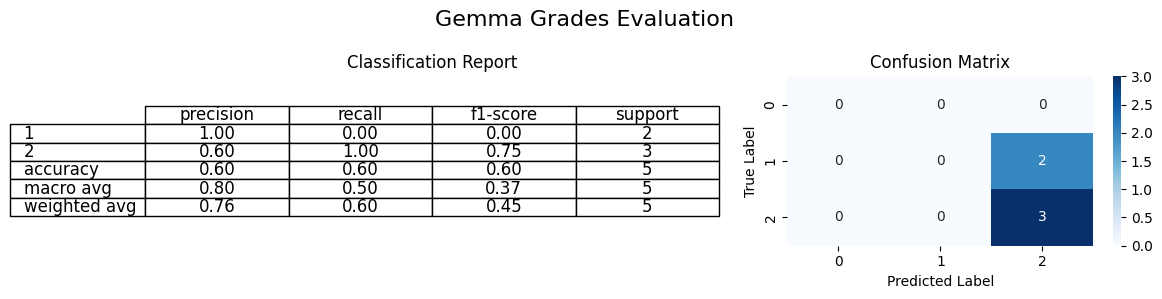

In [ ]:
evaluate_model_grades("0shot")

Percentage of NaN values in 'Gemma_feedback_0shot' that we omitted in metrics: 0.0%


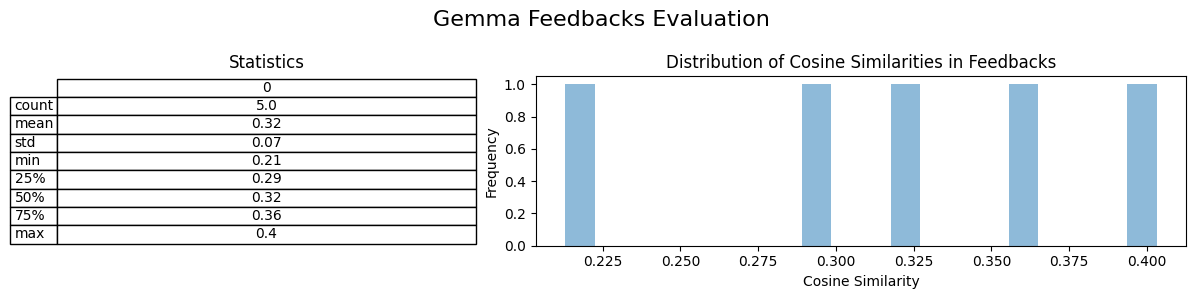

In [ ]:
evaluate_model_feedbacks("0shot")

In [ ]:
results_df.to_csv(f'Results/{model_choice}_results.csv')

#### 0 shot, CoT

In [ ]:
qa_example = test_df.sample()
prompt = get_prompt(qa_example["question"].values[0], qa_example["student_answer"].values[0], qa_example["ref_answer"].values[0], "0shot_cot")
gemma_output = model.generate(prompt, max_length=512)
print(gemma_output)
print("\n\nTrue mark:",qa_example["grades_round"].values[0])


    ## Question:

     Give a definition for the term "artificial neural network" and mention, how it resembles the human brain!

    ## Student Answer:

    Artificial neural network is a massively parrallal distributed processor made up of simple processing units which has a natural propensity to acquire knowledge from the environment and make it available for future use. It resembels the human brain in following ways. 1. Both of them acquire knowledge from the environment. 2. The neurons are connected by synapses cahrecterized by their weights which can be adjusted.

    ## Reference Answer:

    A neural network is a massively parallel distributed processor which is made up of simple processing units. It has a natural propensity for storing experiential knowledge. Neural networks resemble the brain in two aspects; knowledge is acquired by the network from its environment through a learning process, interneuron connection strength known as synaptic weights are used to store the acq

In [ ]:
test_model("0shot_cot", debug_loop_limit=5, verbose=True)

Output()

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 128

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 511

In [ ]:
results_df.head()

,Gemma_grade_fewshot_cot,Gemma_feedback_fewshot_cot,Gemma_grade_0shot,Gemma_feedback_0shot,Gemma_grade_0shot_cot,Gemma_feedback_0shot_cot
499,2.0,The answer captures the essence of the referen...,2.0,Answer captures the essence of the reference a...,2.0,Your answer captures the essence of the refere...
128,2.0,The answer captures the essence of the referen...,2.0,Your answer captures the concept of classifica...,2.0,Your answer captures the essence of the refere...
22,2.0,The student's answer captures the essence of t...,2.0,Answer captures the idea of a neural network a...,2.0,Understand the concept of artificial neural ne...
35,2.0,The student's answer captures the essence of t...,2.0,"Answer captures the main ideas, but misses som...",2.0,Answer captures the main idea of the reference...
511,2.0,The student's answer captures the essence of t...,2.0,Answer captures the essence of the reference a...,2.0,The student captures the essence of the refere...


Percentage of NaN values in 'Gemma_grade_0shot_cot' that we omitted in metrics: 0.0%


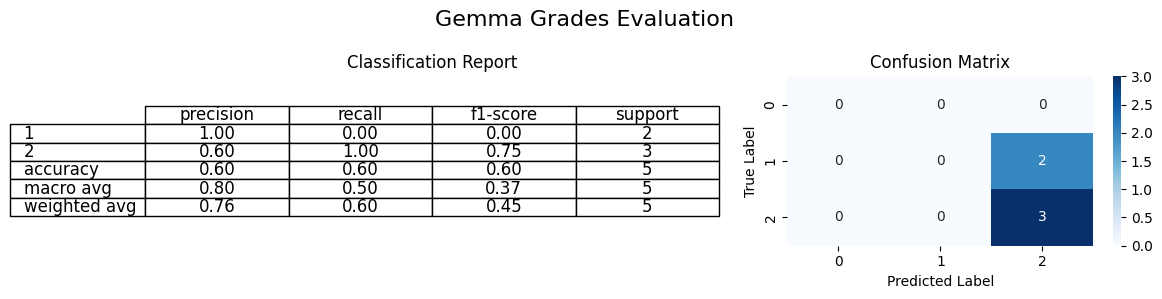

In [ ]:
evaluate_model_grades("0shot_cot")

Percentage of NaN values in 'Gemma_feedback_0shot_cot' that we omitted in metrics: 0.0%


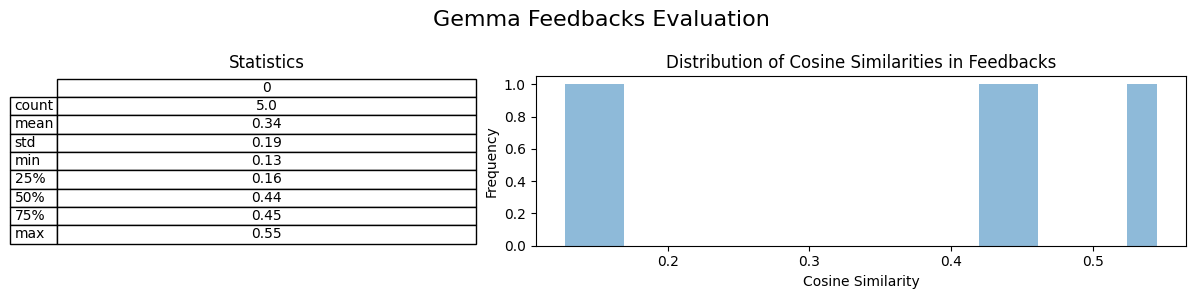

In [ ]:
evaluate_model_feedbacks("0shot_cot")

In [ ]:
results_df.to_csv(f'Results/{model_choice}_results.csv')

#### few shot, CoT

In [ ]:
examples_df = train_df[train_df['question_id'] == 1].groupby('grades_round').first().reset_index()

In [ ]:
qa_example = test_df.sample()
prompt = get_prompt(qa_example["question"].values[0], qa_example["student_answer"].values[0], qa_example["ref_answer"].values[0], "fewshot_cot", examples_df)
gemma_output = model.generate(prompt, max_length=1024)
print(gemma_output)
print("\n\nTrue mark:",qa_example["grades_round"].values[0])


    ## Question:

    Explain back propagation, use the correct technical terms!

    ## Student Answer:

    Back propagation consists of two steps: 1. step - Forward pass: Here the input data is fed into the network and the output is calculated at the output nodes. The usual calculations of the induced local field are done by using this formula $v = \sum wx + b$. The output is then calculated using this formula $y = f(v)$, where f() is the activation function. 2. step - Backward pass: Here the error is backpropagated through the network from the output layer to the input layer. In the output layer the error is calculated using this formula $\delta = d - y$, using the desired output d and the actual output y. In the layers before the output layer the local gradient is used to calculate the error using the error from the output layer $\delta = w\delta x$. Additionally the weights are updated using $w{new} = w{old} - learning\rate \cdot \delta x$

    ## Reference Answer:

    Backprop

In [ ]:
test_model("fewshot_cot", verbose=True, examples_df=examples_df, debug_loop_limit=5)

Output()

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 128

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 511

In [ ]:
results_df.head()

,Gemma_grade_0shot,Gemma_feedback_0shot,Gemma_grade_0shot_cot,Gemma_feedback_0shot_cot,Gemma_grade_fewshot_cot,Gemma_feedback_fewshot_cot
499,2.0,"Answer captures the essence of the reference answer, but misses some details.",2.0,"Your answer captures the essence of the reference answer. However, it misses some minor details.",2.0,"Answer captures the essence of the reference answer, but misses significant points or contains major errors."
128,2.0,"Your answer captures the concept of classification and regression, but misses some details. You should focus on distinguishing between the two tasks.",2.0,"Your answer captures the essence of the reference answer, but misses some details. You could improve your answer by paying attention to the specific requirements of the question.",2.0,"The student captures the essence of the reference answer, but misses some important details. The student should pay attention to the context of the question and provide more detailed answer."
22,2.0,"Answer captures the idea of a neural network and its resemblance to the human brain, but miss details of synaptic connections and learning process.",2.0,"Understand the concept of artificial neural networks, focus on knowledge acquisition and interneurons connection.",2.0,"Answer captures the essence of the reference answer, but misses significant points or contains major errors."
35,2.0,"Answer captures the main ideas, but misses some details and contains few errors.",2.0,"Answer captures the main idea of the reference answer, but misses some details. The response demonstrates an understanding of the concept, and captures key points of the topic.",2.0,"Answer captures the essence of the reference answer, but misses significant points or contains major errors."
511,2.0,"Answer captures the essence of the reference answer, but misses some details about the structure of CNN.",2.0,"The student captures the essence of the reference answer, but misses some details. The student should focus on capturing the essence of the reference answer and then complete the answer with the missing details.",2.0,"Answer captures the essence of the reference answer, but misses significant points or contains major errors."


Percentage of NaN values in 'Gemma_grade_fewshot_cot' that we omitted in metrics: 0.0%


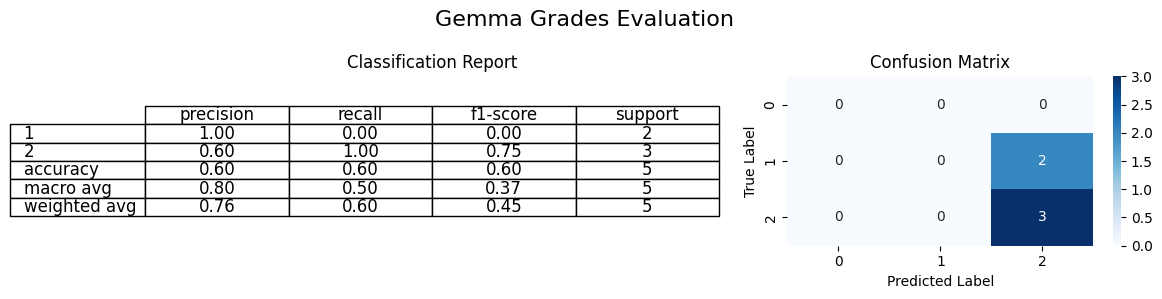

In [ ]:
evaluate_model_grades("fewshot_cot")

Percentage of NaN values in 'Gemma_feedback_fewshot_cot' that we omitted in metrics: 0.0%


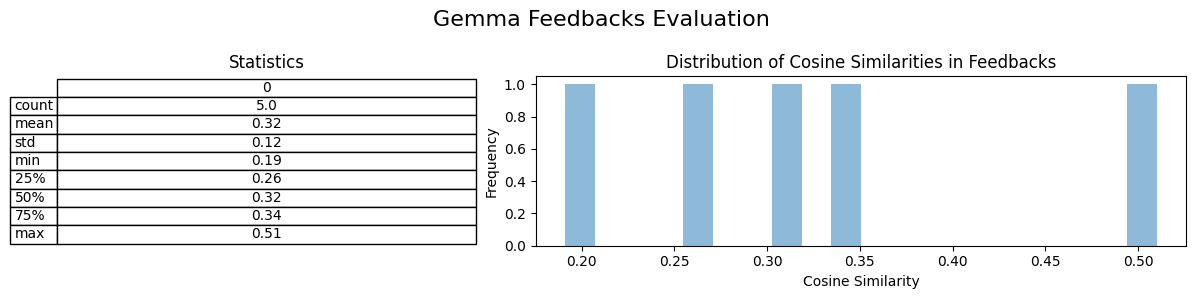

In [ ]:
evaluate_model_feedbacks("fewshot_cot")

In [ ]:
results_df.to_csv(f'Results/{model_choice}_results.csv')

#### Define tuned model TODO rewrite this section

To get better responses from the model, we fine-tune the model with our dataset.

**Documentation:**

The *LoRA rank* determines the dimensionality of the trainable matrices that are added to the original weights of the LLM. It controls the expressiveness and precision of the fine-tuning adjustments.

A higher rank means more detailed changes are possible, but also means more trainable parameters. A lower rank means less computational overhead, but potentially less precise adaptation.

This tutorial uses a LoRA rank of 4. In practice, begin with a relatively small rank (such as 4, 8, 16). This is computationally efficient for experimentation. Train your model with this rank and evaluate the performance improvement on your task. Gradually increase the rank in subsequent trials and see if that further boosts performance.



In [ ]:
model.backbone.enable_lora(rank=2)
model.summary()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                   │                                             256,000 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2048)        │   2,506,854,400 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     524,288,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,506,854,400 (9.34 GB)

 Trainable params: 681,984 (2.60 MB)

 Non-trainable params: 2,506,172,416 (9.34 GB)

Note that enabling LoRA reduces the number of trainable parameters significantly (from 2.5 billion to 1.3 million).

In [ ]:
# @title Preparing dataset

def df_to_finetuning_dataset(df, prompt_type="0shot"):
  """
  Turn a pandas DataFrame into a dataset usuable for Gemma fine tuning.

  #### Parameters:
  :df: pandas DataFrame
  :prompt_type: Select one of the listed prompting options:
    - "0shot": 0 shot prompt
    - "0shot_cot": 0 shot and chain of thought prompt
  """
  data = []

  for _, row in df.iterrows():
    prompt = get_prompt(row["question"], row["student_answer"], row["ref_answer"], prompt_type)

    expected_answer = """
{
  "grade": """
    expected_answer += str(row["grades_round"])
    expected_answer += """,
  "feedback": """
    expected_answer += '"'+str(row["ref_answer"])+'"'
    expected_answer += """
}
```"""
    data.append(prompt+expected_answer)

  return data

data = df_to_finetuning_dataset(train_df)
print(data[0])


    ## Question:

    Write down the SOM learning in pseudo code.

    ## Student Answer:

    input: distance function d(x, y), learning rate mu, neighborhood distance n Initialize the map layer with random weights for each input: find the weight which is closest to the input (minimum d(x, y)) change the weight in the direction of the input depending on the learning rate change all weights which are within the neighborhood distance n depending on their distance and the learning rate reduce learning rate and neighborhood distance

    ## Reference Answer:

    Arrange the weights in the required topology according to the problem. Initialize the weights randomly such that all the weights are different. Sample the input from the input space. Similarity matching: match the input to a neuron in the topological lattice which becomes the winning neuron. Update the weights of the winning neuron and its neighbours determined by the neighbourhood function. Reduce the neighbourhood and decay th

In [ ]:
# @title Fine tuning

# Limit the input sequence length to 512 (to control memory usage).
model.preprocessor.sequence_length = 256 # 512 provocate Out Of Memory
# Use AdamW (a common optimizer for transformer models).
optimizer = keras.optimizers.AdamW(
    learning_rate=5e-5,
    weight_decay=0.01,
)
# Exclude layernorm and bias terms from decay.
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

model.fit(data, epochs=1, batch_size=3)

485/485 ━━━━━━━━━━━━━━━━━━━━ 488s 754ms/step - loss: 2.8577 - sparse_categorical_accuracy: 0.5142


## Analysis


### Fine tune comparison

Original model's performance on few shot and CoT:
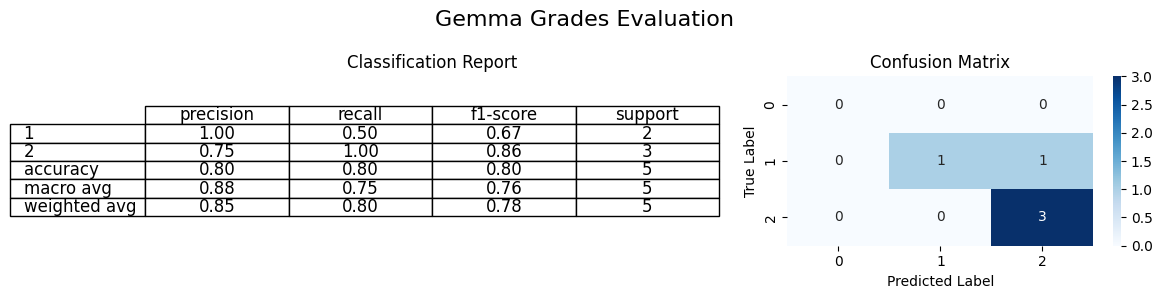


Fine tuned model's performance:
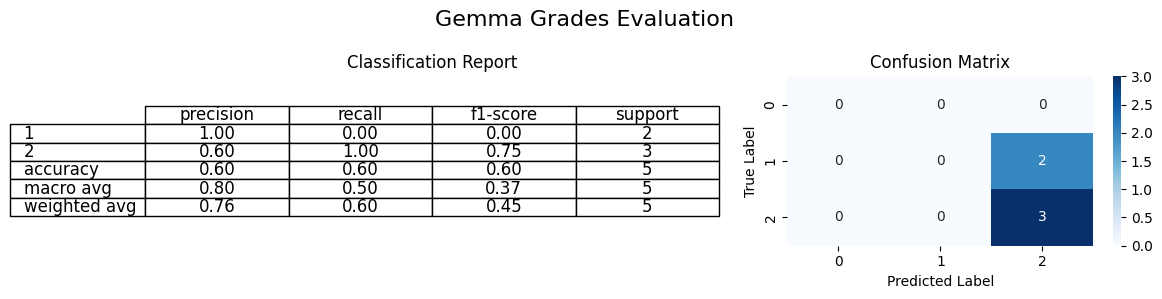


Example of prediction:
- Question: *Give the basic idea of an SVM using the correct terminology!*
- Student answer:
- Grade: $1$

| Model | Feedback | Grade |
|-|-|-|
| Original | The answer captures the essence of the reference answer, but misses significant points. The student should focus on understanding the main ideas of an SVM and how it works, and then fill in the details of the answer. | $2$ |
| Fine tuned |


We observe that the training provocate a perform lost, with Gemma.